COMS 4995<br>
Deep Learning for Computer Vision<br>
Project - Guidance from Language Assistive Sight System (GLASS)<br>
Nirav Agarwal (na3140)<br>
____________________________

This is the initial IPYNB file I was using before shifting to AWS for model training.

In [ ]:
import os
import shutil
import tarfile
import random
import numpy as np
import urllib.request
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
from PIL import Image
import tarfile

In [ ]:
!tar -xvzf /content/IndoorImages.tar.gz
!tar -xvzf /content/OutdoorImages.tar.gz

Streaming output truncated to the last 5000 lines.
IndoorImages/warehouse/warehouse_402.jpg
IndoorImages/warehouse/warehouse_403.jpg
IndoorImages/warehouse/warehouse_404.jpg
IndoorImages/warehouse/warehouse_405.jpg
IndoorImages/warehouse/warehouse_406.jpg
IndoorImages/warehouse/warehouse_407.jpg
IndoorImages/warehouse/warehouse_408.jpg
IndoorImages/warehouse/warehouse_409.jpg
IndoorImages/warehouse/warehouse_41.jpg
IndoorImages/warehouse/warehouse_410.jpg
IndoorImages/warehouse/warehouse_411.jpg
IndoorImages/warehouse/warehouse_412.jpg
IndoorImages/warehouse/warehouse_413.jpg
IndoorImages/warehouse/warehouse_414.jpg
IndoorImages/warehouse/warehouse_415.jpg
IndoorImages/warehouse/warehouse_416.jpg
IndoorImages/warehouse/warehouse_417.jpg
IndoorImages/warehouse/warehouse_418.jpg
IndoorImages/warehouse/warehouse_419.jpg
IndoorImages/warehouse/warehouse_42.jpg
IndoorImages/warehouse/warehouse_420.jpg
IndoorImages/warehouse/warehouse_421.jpg
IndoorImages/warehouse/warehouse_422.jpg
IndoorIm

In [ ]:
#Defining combined dataset directory
dataset_dir = '/content/CombinedDataset'

#Creating the combined dataset directory if it doesn't exist
if not os.path.exists(dataset_dir):
  os.makedirs(dataset_dir)

In [ ]:
#Copying indoor images to the combined dataset directory
print("Combining indoor and outdoor datasets.")
for class_name in os.listdir(indoor_dir):
  source_class_dir = os.path.join(indoor_dir, class_name)
  target_class_dir = os.path.join(dataset_dir, class_name)
  if not os.path.exists(target_class_dir):
    os.makedirs(target_class_dir)
  for img_name in os.listdir(source_class_dir):
    shutil.copyfile(
        os.path.join(source_class_dir, img_name),
        os.path.join(target_class_dir, img_name)
    )

# Copy outdoor images to the combined dataset directory
for class_name in os.listdir(outdoor_dir):
  source_class_dir = os.path.join(outdoor_dir, class_name)
  target_class_dir = os.path.join(dataset_dir, class_name)
  if not os.path.exists(target_class_dir):
    os.makedirs(target_class_dir)
  for img_name in os.listdir(source_class_dir):
    shutil.copyfile(
        os.path.join(source_class_dir, img_name),
        os.path.join(target_class_dir, img_name)
    )

print("Combined dataset created successfully.")

Combining indoor and outdoor datasets.
Combined dataset created successfully.


In [ ]:
#Setting the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Using GPU if available, else CPU
print(f'Using device: {device}') #Printing the device being used

Using device: cuda


In [ ]:
#Defining transformations for the training, validation, and testing sets
data_transforms = {
  'train': transforms.Compose([
    transforms.Resize(320),             #Resizing the image to 320 pixels
    transforms.CenterCrop(224),         #Croping to 224x224 pixels
    transforms.ToTensor(),              #Converting image to PyTorch tensor
  ]),
  'val': transforms.Compose([
    transforms.Resize(320),             #Resizing the image to 320 pixels
    transforms.CenterCrop(224),         #Croping the image to 224x224 pixels
    transforms.ToTensor(),              #Converting image to PyTorch tensor
  ]),
  'test': transforms.Compose([
    transforms.Resize(320),             #Resizing the image to 320 pixels
    transforms.CenterCrop(224),         #Croping the image to 224x224 pixels
    transforms.ToTensor(),              #Converting image to PyTorch tensor
  ]),
}

In [ ]:
dataset = datasets.ImageFolder(dataset_dir, data_transforms['train'])

In [ ]:
#Spliting the dataset into training (80%), validation (10%), and test (10%)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator())

In [ ]:
#Creating data loaders
batch_size = 32 #Batch size
dataloaders = {
  'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True), #Training data loader
  'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False), #Validation data loader
  'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #Test data loader
}

#Getting class names
class_names = dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print("Class Encoding:")
for class_name, class_idx in dataset.class_to_idx.items():
  print(f"{class_name}: {class_idx}")

Number of classes: 84
Class Encoding:
airport_inside: 0
alley: 1
arcade: 2
artstudio: 3
auditorium: 4
bakery: 5
bar: 6
bathroom: 7
bedroom: 8
bookstore: 9
buffet: 10
bus_station: 11
casino: 12
children_room: 13
church_inside: 14
classroom: 15
cloister: 16
closet: 17
clothingstore: 18
computerroom: 19
concert_hall: 20
construction_site: 21
corridor: 22
crosswalk: 23
deli: 24
dentaloffice: 25
dining_room: 26
downtown: 27
elevator: 28
fastfood_restaurant: 29
florist: 30
fountain: 31
gameroom: 32
garage: 33
greenhouse: 34
grocerystore: 35
gym: 36
hairsalon: 37
highway: 38
hospitalroom: 39
inside_bus: 40
jewelleryshop: 41
kindergarden: 42
kitchen: 43
laboratorywet: 44
laundromat: 45
library: 46
livingroom: 47
lobby: 48
locker_room: 49
mall: 50
market: 51
meeting_room: 52
movietheater: 53
museum: 54
nursery: 55
office: 56
operating_room: 57
pantry: 58
park: 59
parking_lot: 60
playground: 61
plaza: 62
poolinside: 63
prisoncell: 64
promenade: 65
restaurant: 66
restaurant_kitchen: 67
shoeshop: 

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

# Freeze initial layers to retain pre-trained features
for param in resnet18.parameters():
  param.requires_grad = False

In [ ]:
#Modifying the final fully connected layer to match the number of classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18.fc.requires_grad = True  #Only train this new layer initially

In [ ]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)

In [ ]:
#Creating a variable for storing the dataset sizes
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']} #Sizes of datasets

In [ ]:
#Defining the training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs, model_name):
  #Here, I am providing the model, dataloaders for training and validation data, loss function (criterion), optimizer, number of epochs, name of model to be saved

  model.to(device)  #Moving the model to GPU

  # Initializing the best validation loss variable to track the best model
  best_val_loss = float('inf') #Setting best validation loss to infinity initially
  # Initializing the history dictionary to store training and validation loss and accuracy
  history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

  for epoch in range(1, num_epochs + 1):  #Iterating through the epochs
    model.train()  #Setting the PyTorch model to training
    running_loss = 0.0  #Initializing the running loss
    correct = 0  #Initializing the correct predictions
    total = 0  #Initializing the total predictions

    for inputs, labels in dataloaders['train']:  #Iterating over the training data
      inputs = inputs.to(device)  #Moving inputs to GPU
      labels = labels.to(device)  #Moving labels to GPU

      optimizer.zero_grad()  #Zeroing the gradients, I've shared on Slack why this is important

      #Forward propagation
      outputs = model(inputs) #Getting model outputs
      loss = criterion(outputs, labels)  #Computing the loss

      #Backward propagation and optimization
      loss.backward() #Computing gradients
      optimizer.step() #Updating parameters

      running_loss = running_loss + (loss.item() * inputs.size(0)) #Computing training running loss

      #Computing the accuracy
      i, preds = torch.max(outputs, 1)  #Getting the index of the max log-probability
      correct = correct + ((preds == labels).sum().item()) #Counting correct predictions
      total = total + labels.size(0) #Counting total predictions

    epoch_loss = running_loss / dataset_sizes['train']  #Computing the training epoch loss
    epoch_acc = correct / total  #Computing the training epoch accuracy
    history['train_loss'].append(epoch_loss) #Recording training loss
    history['train_acc'].append(epoch_acc) #Recording training accuracy

    #Validation
    model.eval()  #Setting the PyTorch model to evaluation
    val_running_loss = 0.0 #Recording training accuracy
    val_correct = 0 #Initializing correct predictions for validation
    val_total = 0 #Initializing total predictions for validation

    with torch.no_grad(): #Disabling gradient calculation, suggested on Slack
      for inputs, labels in dataloaders['val']:  #Iterating over the validation data
        inputs = inputs.to(device) #Moving inputs to GPU
        labels = labels.to(device) #Moving labels to GPU and converting to float

        outputs = model(inputs) #Getting model outputs
        loss = criterion(outputs, labels) #Computing loss
        val_running_loss = val_running_loss + (loss.item() * inputs.size(0)) #Computing validation running loss
        j, preds = torch.max(outputs, 1) #Threshold for the outputs
        val_correct = val_correct + ((preds == labels).sum().item()) #Counting correct predictions
        val_total = val_total + labels.size(0) #Counting total predictions

    val_epoch_loss = val_running_loss / dataset_sizes['val'] #Computing validation epoch loss
    val_epoch_acc = val_correct / val_total #Computing validation epoch accuracy
    history['val_loss'].append(val_epoch_loss) #Recording validation loss
    history['val_acc'].append(val_epoch_acc) #Recording validation accuracy

    #Printing epochs
    print(f'Epoch {epoch}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    #Checking for the best model so far
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss #Updating best validation loss
      torch.save(model.state_dict(), f'{model_name}_best.pth') #Saving the best model
      print(f'The best model is saved at epoch: {epoch}') #Printing best model saved

  return history #Returning the history dict

In [ ]:
#Training the model
num_epochs = 15  #Setting the number of epochs

history = train_model(resnet18, dataloaders, criterion, optimizer, num_epochs, 'resnet18_frozen') #Training the model

Epoch 1/15 - Train Loss: 2.6989, Train Acc: 0.3618, Val Loss: 1.9047, Val Acc: 0.4935
The best model is saved at epoch: 1
Epoch 2/15 - Train Loss: 1.7053, Train Acc: 0.5483, Val Loss: 1.6749, Val Acc: 0.5370
The best model is saved at epoch: 2
Epoch 3/15 - Train Loss: 1.4699, Train Acc: 0.5953, Val Loss: 1.6411, Val Acc: 0.5401
The best model is saved at epoch: 3
Epoch 4/15 - Train Loss: 1.3528, Train Acc: 0.6196, Val Loss: 1.5914, Val Acc: 0.5504
The best model is saved at epoch: 4
Epoch 5/15 - Train Loss: 1.2666, Train Acc: 0.6411, Val Loss: 1.5393, Val Acc: 0.5587
The best model is saved at epoch: 5
Epoch 6/15 - Train Loss: 1.2028, Train Acc: 0.6589, Val Loss: 1.5833, Val Acc: 0.5618
Epoch 7/15 - Train Loss: 1.1499, Train Acc: 0.6680, Val Loss: 1.6132, Val Acc: 0.5437
Epoch 8/15 - Train Loss: 1.0942, Train Acc: 0.6820, Val Loss: 1.5630, Val Acc: 0.5566
Epoch 9/15 - Train Loss: 1.0687, Train Acc: 0.6889, Val Loss: 1.6032, Val Acc: 0.5634
Epoch 10/15 - Train Loss: 1.0303, Train Acc: 0

In [ ]:
def evaluate_model(model, dataloader, criterion, model_name):
  #Same arguements as before

  model.to(device)  #Moving model to GPU
  model.eval()  #Setting PyTorch model to evaluation
  test_loss = 0.0  #Initializing test loss
  correct = 0  #Initializing correct predictions
  total = 0  #Initializing total predictions

  with torch.no_grad():  #Disabling gradient calculation, suggested on Slack
    for inputs, labels in dataloader:  #Iterating over test data
      inputs = inputs.to(device)  #Moving inputs to GPU
      labels = labels.to(device)  #Moving labels to GPU

      outputs = model(inputs)  #Getting model outputs
      loss = criterion(outputs, labels)  #Getting loss
      test_loss = test_loss + (loss.item() * inputs.size(0))  #Computing test running loss
      i, preds = torch.max(outputs, 1)  #Getting predictions
      correct = correct + ((preds == labels).sum().item())  #Counting correct predictions
      total = total + labels.size(0)  #Counting total predictions

  avg_loss = test_loss / dataset_sizes['test']  #Computing average test loss
  accuracy = correct / total  #Computing test accuracy
  print(f'For {model_name} model - Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')  #Printing the test results

  return avg_loss, accuracy  #Returning test loss and accuracy

In [ ]:
#Evaluating the model
evaluate_model(resnet18, dataloaders['test'], criterion, 'resnet18_frozen')

For resnet18_frozen model - Test Loss: 1.6279, Test Accuracy: 0.5669


(1.6278631493102673, 0.5669250645994832)

In [ ]:
#Unfreezing all layers
for layer_parameters in resnet18.parameters():
  layer_parameters.requires_grad = True

#Defining a new optimizer for all layers
optimizer = optim.Adam(resnet18.parameters(), lr=1e-4)  #Using a smaller learning rate for fine-tuning all layers

In [ ]:
#Continuing training the same Resnet18 model
num_epochs = 5  #Additional epochs for fine-tuning
history_finetuned = train_model(resnet18, dataloaders, criterion, optimizer, num_epochs, 'resnet18_unfrozen') #Fine-tuning the model

Epoch 1/5 - Train Loss: 1.0469, Train Acc: 0.6850, Val Loss: 1.4339, Val Acc: 0.6094
The best model is saved at epoch: 1
Epoch 2/5 - Train Loss: 0.2437, Train Acc: 0.9388, Val Loss: 1.3957, Val Acc: 0.6306
The best model is saved at epoch: 2
Epoch 3/5 - Train Loss: 0.0844, Train Acc: 0.9882, Val Loss: 1.3890, Val Acc: 0.6394
The best model is saved at epoch: 3
Epoch 4/5 - Train Loss: 0.0454, Train Acc: 0.9952, Val Loss: 1.4069, Val Acc: 0.6508
Epoch 5/5 - Train Loss: 0.0253, Train Acc: 0.9977, Val Loss: 1.4019, Val Acc: 0.6477


In [ ]:
#Evaluating the model
evaluate_model(resnet18, dataloaders['test'], criterion, 'resnet18_unfrozen')

For resnet18_unfrozen model - Test Loss: 1.4048, Test Accuracy: 0.6641


(1.4047991271474873, 0.6640826873385013)

In [ ]:
#The model is overfitting quite a bit.

In [ ]:
#Defining the function to plot training and validation loss and accuracy
def plot_train_val(history, model_name):
  #Here, I am providing the history dictionary containing loss and accuracy history, and the corresponding model name

  num_epochs = range(1, len(history['train_loss']) + 1)  # Getting the number of epochs

  #Plotting the training and validation loss
  plt.figure(figsize=(12,5))  #Creating a figure of size 12 by 5
  plt.subplot(1,2,1)  #Setting up a grid of subplots and selecting the first subplot
  plt.plot(num_epochs, history['train_loss'], label='Training Loss')  #Plotting training loss
  plt.plot(num_epochs, history['val_loss'], label='Validation Loss')  #Plotting validation loss
  plt.title(f'{model_name} Loss')  #Setting the title
  plt.xlabel('Epochs')  #Labeling the x-axis
  plt.ylabel('Loss')  #Labeling the y-axis
  plt.legend()  #Adding a legend

  #Plotting the training and validation accuracy
  plt.subplot(1,2,2)  #Selecting the second subplot
  plt.plot(num_epochs, history['train_acc'], label='Training Accuracy')  #Plotting training accuracy
  plt.plot(num_epochs, history['val_acc'], label='Validation Accuracy')  #Plotting validation accuracy
  plt.title(f'{model_name} Accuracy')  #Setting the title
  plt.xlabel('Epochs')  #Labeling the x-axis
  plt.ylabel('Accuracy')  #Labeling the y-axis
  plt.legend()  #Adding a legend
  plt.tight_layout()  #Adjusting the layout
  plt.show()  #Displaying the plots

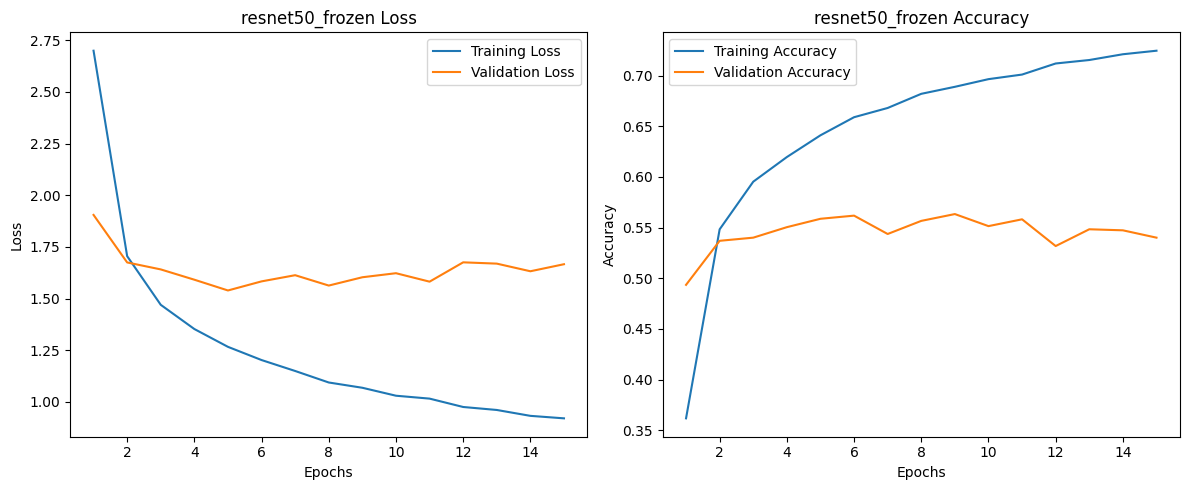

In [ ]:
#Plotting the training and validation loss and accuracy for model
plot_train_val(history, 'resnet50_frozen')

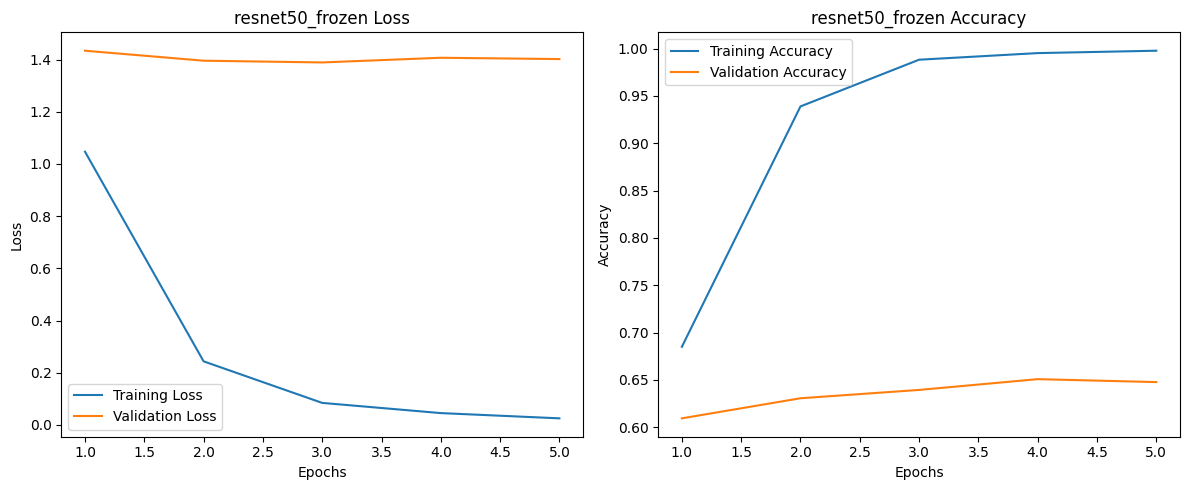

In [ ]:
#Plotting the training and validation loss and accuracy for model
plot_train_val(history_finetuned, 'resnet50_frozen')

In [ ]:
#So, I will remedy by doing some data agumentation.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(320),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

In [ ]:
# Assuming dataset_dir contains all the images organized by classes
train_dataset = datasets.ImageFolder(root=dataset_dir, transform=data_transforms['train'])

In [ ]:
# Define the dataset size for splitting (using train_dataset here, as it includes all the images)
dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size], generator=torch.Generator())

# Update the transforms for val and test subsets
val_subset.dataset.transform = data_transforms['val']
test_subset.dataset.transform = data_transforms['test']

# Creating data loaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_subset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_subset, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_subset, batch_size=batch_size, shuffle=False)
}

# Getting class names
class_names = train_dataset.classes
num_classes = len(class_names)

In [ ]:
resnet18_exp2 = models.resnet18(pretrained=True)
resnet18_exp2 = resnet18_exp2.to(device)

# Freeze initial layers to retain pre-trained features
for param in resnet18_exp2.parameters():
  param.requires_grad = False

In [ ]:
#Modifying the final fully connected layer to match the number of classes
resnet18_exp2.fc = nn.Linear(resnet18_exp2.fc.in_features, num_classes)
resnet18_exp2.fc.requires_grad = True  #Only train this new layer initially

In [ ]:
#Add weight decay to prevent the model from overfitting
optimizer = optim.Adam(resnet18_exp2.parameters(), lr=0.001)

In [ ]:
#Creating a variable for storing the dataset sizes
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']} #Sizes of datasets

In [ ]:
#Defining the training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs, model_name):
  #Here, I am providing the model, dataloaders for training and validation data, loss function (criterion), optimizer, number of epochs, name of model to be saved

  model.to(device)  #Moving the model to GPU

  # Initializing the best validation loss variable to track the best model
  best_val_loss = float('inf') #Setting best validation loss to infinity initially
  # Initializing the history dictionary to store training and validation loss and accuracy
  history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

  for epoch in range(1, num_epochs + 1):  #Iterating through the epochs
    model.train()  #Setting the PyTorch model to training
    running_loss = 0.0  #Initializing the running loss
    correct = 0  #Initializing the correct predictions
    total = 0  #Initializing the total predictions

    for inputs, labels in dataloaders['train']:  #Iterating over the training data
      inputs = inputs.to(device)  #Moving inputs to GPU
      labels = labels.to(device)  #Moving labels to GPU

      optimizer.zero_grad()  #Zeroing the gradients, I've shared on Slack why this is important

      #Forward propagation
      outputs = model(inputs) #Getting model outputs
      loss = criterion(outputs, labels)  #Computing the loss

      #Backward propagation and optimization
      loss.backward() #Computing gradients
      optimizer.step() #Updating parameters

      running_loss = running_loss + (loss.item() * inputs.size(0)) #Computing training running loss

      #Computing the accuracy
      i, preds = torch.max(outputs, 1)  #Getting the index of the max log-probability
      correct = correct + ((preds == labels).sum().item()) #Counting correct predictions
      total = total + labels.size(0) #Counting total predictions

    epoch_loss = running_loss / dataset_sizes['train']  #Computing the training epoch loss
    epoch_acc = correct / total  #Computing the training epoch accuracy
    history['train_loss'].append(epoch_loss) #Recording training loss
    history['train_acc'].append(epoch_acc) #Recording training accuracy

    #Validation
    model.eval()  #Setting the PyTorch model to evaluation
    val_running_loss = 0.0 #Recording training accuracy
    val_correct = 0 #Initializing correct predictions for validation
    val_total = 0 #Initializing total predictions for validation

    with torch.no_grad(): #Disabling gradient calculation, suggested on Slack
      for inputs, labels in dataloaders['val']:  #Iterating over the validation data
        inputs = inputs.to(device) #Moving inputs to GPU
        labels = labels.to(device) #Moving labels to GPU and converting to float

        outputs = model(inputs) #Getting model outputs
        loss = criterion(outputs, labels) #Computing loss
        val_running_loss = val_running_loss + (loss.item() * inputs.size(0)) #Computing validation running loss
        j, preds = torch.max(outputs, 1) #Threshold for the outputs
        val_correct = val_correct + ((preds == labels).sum().item()) #Counting correct predictions
        val_total = val_total + labels.size(0) #Counting total predictions

    val_epoch_loss = val_running_loss / dataset_sizes['val'] #Computing validation epoch loss
    val_epoch_acc = val_correct / val_total #Computing validation epoch accuracy
    history['val_loss'].append(val_epoch_loss) #Recording validation loss
    history['val_acc'].append(val_epoch_acc) #Recording validation accuracy

    #Printing epochs
    print(f'Epoch {epoch}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    #Checking for the best model so far
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss #Updating best validation loss
      torch.save(model.state_dict(), f'{model_name}_best.pth') #Saving the best model
      print(f'The best model is saved at epoch: {epoch}') #Printing best model saved

  return history #Returning the history dict

In [ ]:
#Training the model
num_epochs = 15  #Setting the number of epochs

history_exp2 = train_model(resnet18_exp2, dataloaders, criterion, optimizer, num_epochs, 'resnet18_exp2_frozen') #Training the model

Epoch 1/15 - Train Loss: 2.6822, Train Acc: 0.3649, Val Loss: 1.9396, Val Acc: 0.4816
The best model is saved at epoch: 1
Epoch 2/15 - Train Loss: 1.7059, Train Acc: 0.5479, Val Loss: 1.7104, Val Acc: 0.5225
The best model is saved at epoch: 2
Epoch 3/15 - Train Loss: 1.4692, Train Acc: 0.6005, Val Loss: 1.6633, Val Acc: 0.5272
The best model is saved at epoch: 3
Epoch 4/15 - Train Loss: 1.3401, Train Acc: 0.6247, Val Loss: 1.5507, Val Acc: 0.5634
The best model is saved at epoch: 4
Epoch 5/15 - Train Loss: 1.2696, Train Acc: 0.6392, Val Loss: 1.6166, Val Acc: 0.5510
Epoch 6/15 - Train Loss: 1.2027, Train Acc: 0.6563, Val Loss: 1.5459, Val Acc: 0.5613
The best model is saved at epoch: 6
Epoch 7/15 - Train Loss: 1.1372, Train Acc: 0.6715, Val Loss: 1.6055, Val Acc: 0.5489
Epoch 8/15 - Train Loss: 1.1052, Train Acc: 0.6785, Val Loss: 1.5731, Val Acc: 0.5680
Epoch 9/15 - Train Loss: 1.0723, Train Acc: 0.6847, Val Loss: 1.6183, Val Acc: 0.5504
Epoch 10/15 - Train Loss: 1.0345, Train Acc: 0

In [ ]:
#Evaluating the model
evaluate_model(resnet18_exp2, dataloaders['test'], criterion, 'resnet18_exp2_frozen')

For resnet18_exp2_frozen model - Test Loss: 1.6225, Test Accuracy: 0.5612


(1.6225206523594622, 0.5612403100775194)

In [ ]:
#Unfreezing all layers
for layer_parameters in resnet18_exp2.parameters():
  layer_parameters.requires_grad = True

In [ ]:
#Continuing training the same Resnet18 model
num_epochs = 5  #Additional epochs for fine-tuning
history_finetuned = train_model(resnet18_exp2, dataloaders, criterion, optimizer, num_epochs, 'resnet18_exp2_unfrozen') #Fine-tuning the model

Epoch 1/5 - Train Loss: 2.5309, Train Acc: 0.3542, Val Loss: 2.6134, Val Acc: 0.3430
The best model is saved at epoch: 1
Epoch 2/5 - Train Loss: 1.7573, Train Acc: 0.5117, Val Loss: 2.1145, Val Acc: 0.4609
The best model is saved at epoch: 2
Epoch 3/5 - Train Loss: 1.3433, Train Acc: 0.6090, Val Loss: 2.0609, Val Acc: 0.4718
The best model is saved at epoch: 3
Epoch 4/5 - Train Loss: 1.0566, Train Acc: 0.6850, Val Loss: 2.3765, Val Acc: 0.4361
Epoch 5/5 - Train Loss: 0.7965, Train Acc: 0.7545, Val Loss: 2.3898, Val Acc: 0.4532


In [ ]:
#Evaluating the model
evaluate_model(resnet18_exp2, dataloaders['test'], criterion, 'resnet18_exp2_unfrozen')

For resnet18_exp2_unfrozen model - Test Loss: 2.2982, Test Accuracy: 0.4698


(2.298205423231889, 0.4697674418604651)

In [ ]:
#Even after this the accuracy is quite low, so I will now use a different pre-trained model that is better suited for this task

In [ ]:
# Define the transformations for training, validation, and testing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(320),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Create datasets for train, val, and test splits
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=data_transforms['train'])

# Split the dataset into train (80%), val (10%), and test (10%)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Update the transforms for validation and test datasets
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create DataLoaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

# Get the number of classes from the dataset
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 84


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Download the pre-trained ResNet50 weights for Places365
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -P /content/models/

--2024-11-30 05:18:00--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘/content/models/resnet50_places365.pth.tar’

resnet50_places365. 100%[===================>]  92.76M  8.47MB/s    in 13s     

2024-11-30 05:18:13 (7.16 MB/s) - ‘/content/models/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
resnet50 = models.resnet50(pretrained=False)  # We load the architecture without default weights
resnet50.fc = nn.Linear(resnet50.fc.in_features, 365)

In [ ]:
# Load the downloaded Places365 weights into the model
checkpoint = torch.load('/content/models/resnet50_places365.pth.tar', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
state_dict = {k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}
resnet50.load_state_dict(state_dict)


<ipython-input-166-90b0085a1eef>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/models/resnet50_places365.pth.tar', map_location=torch.de

<All keys matched successfully>

In [ ]:
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50 = resnet50.to(device)

In [ ]:
# Freeze all the convolutional layers (only train the FC layer initially)
for param in resnet50.parameters():
    param.requires_grad = False

# Only train the fully connected layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Define the criterion, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet50.fc.parameters(), lr=0.001, weight_decay=0.01)


In [ ]:
history_exp3 = train_model(resnet50, dataloaders, criterion, optimizer, num_epochs, 'resnet50_exp3_frozen') #Training the model

Epoch 1/5 - Train Loss: 1.5201, Train Acc: 0.6254, Val Loss: 0.9016, Val Acc: 0.7336
The best model is saved at epoch: 1
Epoch 2/5 - Train Loss: 0.8503, Train Acc: 0.7486, Val Loss: 0.8113, Val Acc: 0.7470
The best model is saved at epoch: 2
Epoch 3/5 - Train Loss: 0.7465, Train Acc: 0.7728, Val Loss: 0.7940, Val Acc: 0.7594
The best model is saved at epoch: 3
Epoch 4/5 - Train Loss: 0.6748, Train Acc: 0.7876, Val Loss: 0.8087, Val Acc: 0.7563
Epoch 5/5 - Train Loss: 0.6428, Train Acc: 0.7971, Val Loss: 0.7788, Val Acc: 0.7501
The best model is saved at epoch: 5


In [ ]:
history_exp3 = train_model(resnet50, dataloaders, criterion, optimizer, 10, 'resnet50_exp4_frozen') #Training the model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 - Train Loss: 0.5302, Train Acc: 0.8281, Val Loss: 0.7878, Val Acc: 0.7651
The best model is saved at epoch: 1
Epoch 2/10 - Train Loss: 0.5095, Train Acc: 0.8346, Val Loss: 0.7989, Val Acc: 0.7677
Epoch 3/10 - Train Loss: 0.4852, Train Acc: 0.8403, Val Loss: 0.8453, Val Acc: 0.7538
Epoch 4/10 - Train Loss: 0.4808, Train Acc: 0.8421, Val Loss: 0.8208, Val Acc: 0.7558
Epoch 5/10 - Train Loss: 0.4595, Train Acc: 0.8467, Val Loss: 0.8486, Val Acc: 0.7517
Epoch 6/10 - Train Loss: 0.4435, Train Acc: 0.8542, Val Loss: 0.8425, Val Acc: 0.7558


In [ ]:
#Evaluating the model
evaluate_model(resnet50, dataloaders['test'], criterion, 'resnet50_exp3_frozen')

For resnet50_exp3_frozen model - Test Loss: 0.8096, Test Accuracy: 0.7550


(0.8095854962827007, 0.7550387596899225)

In [ ]:
#Unfreezing all layers
for layer_parameters in resnet50.parameters():
  layer_parameters.requires_grad = True

In [ ]:
#Continuing training the same Resnet18 model
num_epochs = 5  #Additional epochs for fine-tuning
history_finetuned = train_model(resnet50, dataloaders, criterion, optimizer, num_epochs, 'resnet50_exp3_unfrozen') #Fine-tuning the model

Epoch 1/5 - Train Loss: 0.5998, Train Acc: 0.8082, Val Loss: 0.7830, Val Acc: 0.7631
The best model is saved at epoch: 1
Epoch 2/5 - Train Loss: 0.5751, Train Acc: 0.8134, Val Loss: 0.8026, Val Acc: 0.7594
Epoch 3/5 - Train Loss: 0.5435, Train Acc: 0.8262, Val Loss: 0.7693, Val Acc: 0.7708
The best model is saved at epoch: 3
Epoch 4/5 - Train Loss: 0.5186, Train Acc: 0.8266, Val Loss: 0.8788, Val Acc: 0.7450
Epoch 5/5 - Train Loss: 0.5107, Train Acc: 0.8317, Val Loss: 0.8448, Val Acc: 0.7496


In [ ]:
#Evaluating the model
evaluate_model(resnet50, dataloaders['test'], criterion, 'resnet50_exp3_unfrozen')

For resnet50_exp3_unfrozen model - Test Loss: 0.8343, Test Accuracy: 0.7633


(0.8342839163403178, 0.7633074935400517)

The model needs more fune-tuning, and I've to try some more hyperparameters tuning, but due to limit of Colan GPUs, I will shift to a cloud VM.